In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, ccf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
from contextlib import redirect_stdout, redirect_stderr
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.ardl import ARDL, ardl_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import matplotlib.ticker as mtick
import seaborn as sns

In [18]:
yield10y = pd.read_csv('./Datasets/10Yrs_Yield_unadjusted.csv')
cpi = pd.read_csv('./Datasets/CPI-U_unadjusted.csv')
fedFunds = pd.read_csv('./Datasets/FEDFUNDS.csv')
indProd = pd.read_csv('./Datasets/Industrial_Production.csv')
joblessClaim = pd.read_csv('./Datasets/Initial_jobless_claims.csv')
msciUsaValue = pd.read_csv('./Datasets/MSCI_USA_Value_Index.csv')
realGdp = pd.read_csv('./Datasets/RealGDP_adjusted.csv')
sp500Eps = pd.read_csv('./Datasets/s-p-500-earnings-history.csv')
vix = pd.read_csv('./Datasets/VIX_cboe_History.csv')

In [19]:
dfs_dict = {}
dfs_dict["10Yrs_Yield_unadjusted"] = yield10y
dfs_dict["CPI-U_unadjusted"] = cpi
dfs_dict["FEDFUNDS"] = fedFunds
dfs_dict["Industrial_Production"] = indProd
dfs_dict["Initial_Jobless_Claims"] = joblessClaim
dfs_dict["MSCI_USA_Value_Index"] = msciUsaValue
dfs_dict["RealGDP_adjusted"] = realGdp
dfs_dict["S&P_500_Earnings_History"] = sp500Eps
dfs_dict["VIX_Cboe_History"] = vix

In [20]:
def parse_datasets(df_list, dfs_dict):
    for name in df_list:
        try:
            df = dfs_dict[name]
            df_new = df.rename(columns={df.columns[0]: 'DateTime'})
            df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])
            df_new.set_index('DateTime', inplace=True)
            df_new = df_new.sort_index()
            df_new = df_new[(df_new.index >='1999-01-01') & (df_new.index < '2026-01-01')]
            if df_new.columns.size < 2:
                df_new = df_new.rename(columns={df_new.columns[0]: 'value1'})
            dfs_dict[name] = df_new
        except Exception as e:
            print(f"Error in {name}: {e}")
            continue
    return dfs_dict

In [23]:
def get_train_test(df, split_date='2020-01-01'):
    train = df[df.index < split_date]
    test = df[df.index >= split_date]
    return train, test

def wrap_train_test(dfs_dict):
    dfs_dict_train = {}
    dfs_dict_test = {}
    for key, val in dfs_dict.items():
        dfs_dict_train[key], dfs_dict_test[key] = get_train_test(val, '2020-01-01')
    return dfs_dict_train, dfs_dict_test

In [24]:
def plot_timelines(df_list, dfs_dict):
    rows = []
    for name in df_list:
        try:
            df = dfs_dict[name]
            start_time = df.index.min()
            end_time = df.index.max()
            max_interval = df.index.diff().max()
            rows.append({'Name': name, 'start': start_time, 'end': end_time, 'max_interval': max_interval})
        except Exception as e:
            print(f"Error in {name}: {e}")
            continue
    df_new = pd.DataFrame(rows)
    df_new.set_index('Name', inplace=True)
    return df_new

In [25]:
#to be used only for CPI-U and RealGDP_adjusted
def to_pct_change(df):
    df_pct = df.pct_change()
    return df_pct

In [26]:
dfs_dict_new = parse_datasets(list(dfs_dict.keys()), dfs_dict)
dfs_dict_train, dfs_dict_test = wrap_train_test(dfs_dict_new)
train_timeline_df = plot_timelines(list(dfs_dict_train.keys()), dfs_dict_train)

/tmp/ipython-input-3654836538.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])
/tmp/ipython-input-3654836538.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_new['DateTime'] = pd.to_datetime(df_new['DateTime'])


In [27]:
display(train_timeline_df)

,start,end,max_interval
Name,,,
10Yrs_Yield_unadjusted,1999-01-01,2019-12-31,3 days
CPI-U_unadjusted,1999-01-01,2019-12-01,31 days
FEDFUNDS,1999-01-01,2019-12-01,31 days
Industrial_Production,1999-01-01,2019-12-01,31 days
Initial_Jobless_Claims,1999-01-02,2019-12-28,7 days
MSCI_USA_Value_Index,1999-01-01,2019-12-01,31 days
RealGDP_adjusted,1999-01-01,2019-10-01,92 days
S&P_500_Earnings_History,1999-01-01,2019-12-01,31 days
VIX_Cboe_History,1999-01-04,2019-12-31,7 days


In [29]:
test_timeline_df = plot_timelines(list(dfs_dict_test.keys()), dfs_dict_test)
display(test_timeline_df)

,start,end,max_interval
Name,,,
10Yrs_Yield_unadjusted,2020-01-01,2025-12-31,3 days
CPI-U_unadjusted,2020-01-01,2025-12-01,31 days
FEDFUNDS,2020-01-01,2025-12-01,31 days
Industrial_Production,2020-01-01,2025-12-01,31 days
Initial_Jobless_Claims,2020-01-04,2025-12-27,7 days
MSCI_USA_Value_Index,2020-01-01,2025-12-01,31 days
RealGDP_adjusted,2020-01-01,2025-07-01,92 days
S&P_500_Earnings_History,2020-01-01,2025-12-01,31 days
VIX_Cboe_History,2020-01-02,2025-12-31,4 days


In [37]:
def get_recession_periods(recessions):
    recession_periods = []
    for start, end in recessions:
        recession_periods.append((pd.to_datetime(start), pd.to_datetime(end)))
    return recession_periods
recessions = [('2001-03-01', '2001-11-01'), ('2007-12-01', '2009-06-01'), ('2020-02-01', '2020-04-01')]
recession_periods = get_recession_periods(recessions)

In [38]:
def plot_vs_vix(dfs_dict, vix_df, recessions, vix_style='line'):
    non_vix_dfs = {k: v for k, v in dfs_dict.items() if k != 'VIX_Cboe_History'}

    start_data = vix_df.index.min()
    end_data = vix_df.index.max()

    fig, axes = plt.subplots(len(non_vix_dfs), 1, figsize=(20, len(non_vix_dfs)*7))
    if len(non_vix_dfs) == 1:
        axes = [axes]

    for i, (name, df) in enumerate(non_vix_dfs.items()):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        # Plot main data
        if name == 'S&P_500_Earnings_History':
            ax1.plot(df.index, df.iloc[:, 0], label='S&P 500', color='blue')
            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))
            ax3.plot(df.index, df.iloc[:, 1], label='EPS', color='black', linestyle='--')
            ax3.set_ylabel('EPS', color='black')
            ax3.legend(loc='upper center')
        else:
            ax1.plot(df.index, df.iloc[:, 0], label=name, color='blue')

        # Plot VIX
        if vix_style == 'candlestick':
            # Simple bar representation here
            colors = ['green' if vix_df.iloc[j, 3] >= vix_df.iloc[j, 0] else 'red' for j in range(len(vix_df))]
            ax2.bar(vix_df.index, vix_df.iloc[:, 3] - vix_df.iloc[:, 0],
                   bottom=vix_df.iloc[:, 0], width=1, color=colors, alpha=0.3, label='VIX')
        else:
            ax2.plot(vix_df.index, vix_df.iloc[:, 3], label='VIX Close', color='red', alpha=0.6)

        # Shade recessions
        for start, end in recessions:
            if (start_data <= start <= end_data) and (start_data <= end <= end_data):
              ax1.axvspan(start, end, alpha=0.2, color='gray', zorder=0)

        ax1.set_ylabel(name, color='blue')
        ax2.set_ylabel('VIX', color='red')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax1.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [39]:
def change_dtype(df):
    df['value1'] = pd.to_numeric(df['value1'], errors='coerce')
    return df
dfs_dict_train['CPI-U_unadjusted'] = change_dtype(dfs_dict_train['CPI-U_unadjusted'])
dfs_dict_test['CPI-U_unadjusted'] = change_dtype(dfs_dict_test['CPI-U_unadjusted'])

/tmp/ipython-input-2515666796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value1'] = pd.to_numeric(df['value1'], errors='coerce')


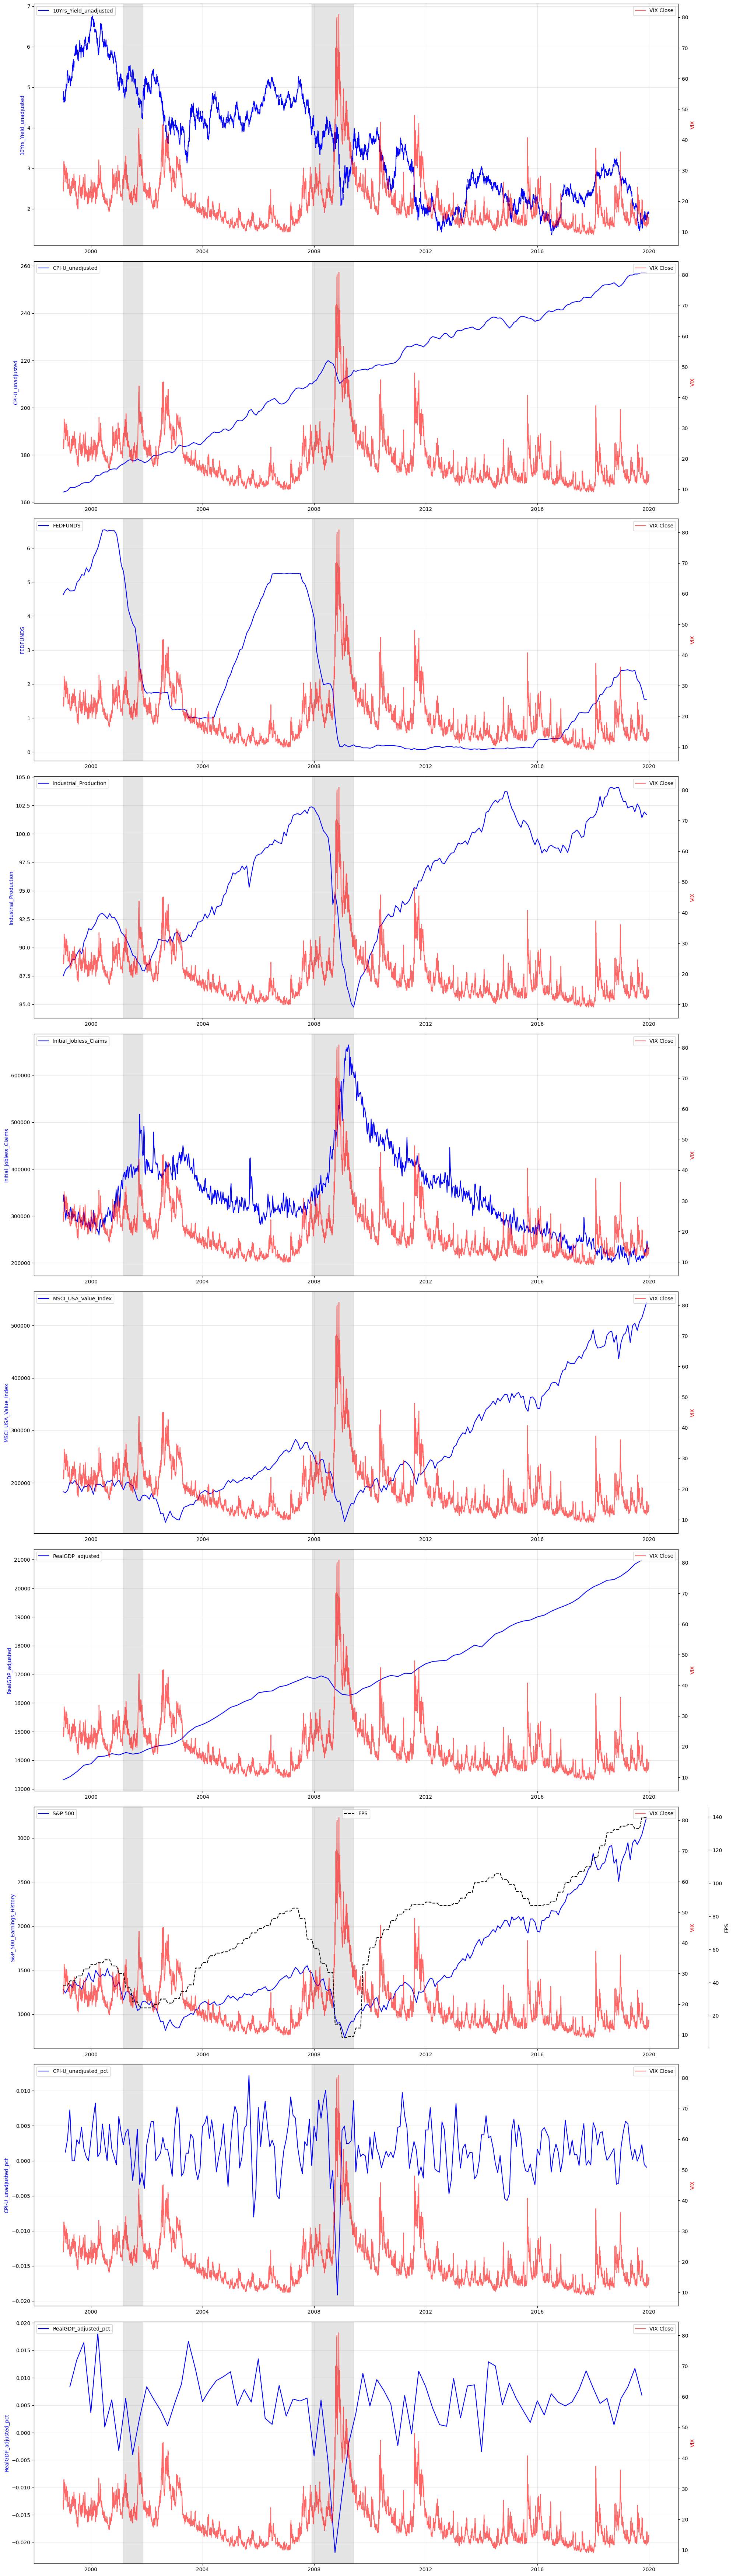

In [40]:
dfs_dict_train['CPI-U_unadjusted_pct'] = to_pct_change(dfs_dict_train['CPI-U_unadjusted'])
dfs_dict_train['RealGDP_adjusted_pct'] = to_pct_change(dfs_dict_train['RealGDP_adjusted'])
plot_vs_vix(dfs_dict_train, dfs_dict_train['VIX_Cboe_History'], recessions=recession_periods, vix_style='line')

In [41]:
def detect_freq(df):
    deltas = df.index.to_series().diff().dt.days.dropna()
    max_delta = deltas.max()

    if max_delta <= 10:
        return 'W'
    elif max_delta <= 40:
        return 'ME'
    else:
        return 'QE'

In [42]:
def choose_common_freq(freq1, freq2):
    freq_order = ['W', 'ME', 'QE']
    f1 = freq1 if freq1 in freq_order else 'QE'
    f2 = freq2 if freq2 in freq_order else 'QE'

    idx1 = freq_order.index(f1)
    idx2 = freq_order.index(f2)

    common_freq = freq_order[max(idx1, idx2)]
    return common_freq

In [43]:
def adaptive_ccf(dfs_dict_train, df1_name, df2_name='VIX_Cboe_History', max_lags=10):
    freq1 = detect_freq(dfs_dict_train[df1_name])
    freq2 = detect_freq(dfs_dict_train[df2_name])
    common_freq = choose_common_freq(freq1, freq2)

    series1 = dfs_dict_train[df1_name].iloc[:, 0].dropna()
    series2 = dfs_dict_train[df2_name].iloc[:, 3].dropna()

    s1_resampled = series1.resample(common_freq).last()
    s2_resampled = series2.resample(common_freq).last()

    start = max(s1_resampled.index.min(), s2_resampled.index.min())
    end = min(s1_resampled.index.max(), s2_resampled.index.max())

    s1_aligned = s1_resampled[start:end]
    s2_aligned = s2_resampled[start:end]

    s1_clean = s1_aligned.dropna()
    s2_clean = s2_aligned.dropna()

    return (common_freq, ccf(s1_clean, s2_clean, adjusted=False)[:max_lags+1])

In [44]:
# ccf has a number of assumptions, namely -
# Weak stationarity
# Linear relationship
# Constant variance
correlations_dict = {}
for name, dataset in dfs_dict_train.items():
    if name != 'VIX_Cboe_History':
        correlations_dict[name] = adaptive_ccf(dfs_dict_train, name)
print(correlations_dict)

{'10Yrs_Yield_unadjusted': ('W', array([0.16861396, 0.16504516, 0.15892964, 0.15426771, 0.14757068,
       0.14146375, 0.1355072 , 0.13025183, 0.1268747 , 0.12623402,
       0.12635161])), 'CPI-U_unadjusted': ('ME', array([-0.32792211, -0.33028381, -0.32739431, -0.32169125, -0.31701251,
       -0.31454563, -0.30964896, -0.30478267, -0.30523431, -0.30223155,
       -0.29976374])), 'FEDFUNDS': ('ME', array([-0.00848258, -0.04140919, -0.06775385, -0.08810832, -0.10264702,
       -0.11551543, -0.12879498, -0.14213078, -0.15495452, -0.16808129,
       -0.18099091])), 'Industrial_Production': ('ME', array([-0.5499813 , -0.58035304, -0.61572471, -0.6427311 , -0.65554631,
       -0.6668421 , -0.67501483, -0.67612272, -0.67511681, -0.66617025,
       -0.65413285])), 'Initial_Jobless_Claims': ('W', array([0.59162793, 0.59947411, 0.60726487, 0.61413154, 0.61930542,
       0.62410066, 0.62663027, 0.62889663, 0.63260022, 0.63524712,
       0.63667625])), 'MSCI_USA_Value_Index': ('ME', array([-0.512

In [62]:
def adaptive_rolling_mi(dfs_dict_train, df1_name, df2_name='VIX_Cboe_History', window_size=100):
    freq1 = detect_freq(dfs_dict_train[df1_name])
    freq2 = detect_freq(dfs_dict_train[df2_name])
    common_freq = choose_common_freq(freq1, freq2)

    series1 = dfs_dict_train[df1_name].iloc[:, 0].dropna()
    series2 = dfs_dict_train[df2_name].iloc[:, 3].dropna()

    s1_resampled = series1.resample(common_freq).last()
    s2_resampled = series2.resample(common_freq).last()

    start = max(s1_resampled.index.min(), s2_resampled.index.min())
    end = min(s1_resampled.index.max(), s2_resampled.index.max())

    s1_aligned = s1_resampled[start:end]
    s2_aligned = s2_resampled[start:end]

    s1_clean = s1_aligned.dropna()
    s2_clean = s2_aligned.dropna()

    df = pd.DataFrame({'X': s1_clean, 'Y': s2_clean})

    mi_scores = []
    try:
      for i in range(len(df) - window_size):
          window = df.iloc[i:i+window_size]
          score = mutual_info_regression(df[['X']], df['Y'])[0]
          mi_scores.append(score)
    except Exception as e:
      print(f"Error in adaptive_rolling_mi: {e}")
      print(f"df: {df1_name}")
    return mi_scores

# wrap adaptive_rolling_mi
def wrap_adaptive_rolling_mi(dfs_dict_train, vix_name='VIX_Cboe_History', window_size=36):
    mi_scores = {}
    for name in dfs_dict_train.keys():
      # print(name)
        if name != vix_name:
            mi_scores[name] = adaptive_rolling_mi(dfs_dict_train, df1_name=name, df2_name=vix_name, window_size=window_size)
    return mi_scores

# Compute rolling MI
rolling_mi_results = wrap_adaptive_rolling_mi(dfs_dict_train)

In [63]:
print(rolling_mi_results.keys())

dict_keys(['10Yrs_Yield_unadjusted', 'CPI-U_unadjusted', 'FEDFUNDS', 'Industrial_Production', 'Initial_Jobless_Claims', 'MSCI_USA_Value_Index', 'RealGDP_adjusted', 'S&P_500_Earnings_History', 'CPI-U_unadjusted_pct', 'RealGDP_adjusted_pct'])


In [76]:
print(rolling_mi_results['RealGDP_adjusted_pct'])

[np.float64(0.031060381923257108), np.float64(0.03206439798751415), np.float64(0.03387684257104295), np.float64(0.03481465977392029), np.float64(0.03387684257104295), np.float64(0.031060381923257108), np.float64(0.0309941830618774), np.float64(0.03481465977392029), np.float64(0.03206439798751415), np.float64(0.034880858635299994), np.float64(0.0309941830618774), np.float64(0.03481465977392029), np.float64(0.03387684257104295), np.float64(0.03206439798751415), np.float64(0.033810643709663246), np.float64(0.031060381923257108), np.float64(0.03206439798751415), np.float64(0.03481465977392029), np.float64(0.03199819912613444), np.float64(0.03206439798751415), np.float64(0.03387684257104295), np.float64(0.03481465977392029), np.float64(0.033810643709663246), np.float64(0.03199819912613444), np.float64(0.03481465977392029), np.float64(0.034880858635299994), np.float64(0.034880858635299994), np.float64(0.03199819912613444), np.float64(0.03387684257104295), np.float64(0.0309941830618774), np.f

In [45]:
def analyze_ccf(dfs_dict_train, correlations_dict, name1, name2, col_name='value1', max_lags=10):
    freq, correlations = correlations_dict.get(name1)
    lags = np.arange(len(correlations))

    # Confidence interval
    n = len(dfs_dict_train[name1][col_name].resample(freq).last().dropna())
    conf_interval = 2.576 / np.sqrt(n)

    # Find significant peaks
    significant = np.abs(correlations) > conf_interval
    significant_lags = lags[significant]

    # Find maximum correlation
    max_idx = np.argmax(np.abs(correlations[1:])) + 1  # Skip lag 0
    max_corr = correlations[max_idx]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.stem(lags, correlations, basefmt=' ')
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.axhline(y=conf_interval, color='red', linestyle='--', alpha=0.7, label=f'99% CI (±{conf_interval:.3f})')
    ax.axhline(y=-conf_interval, color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('Lag (periods)', fontsize=12)
    ax.set_ylabel('Correlation', fontsize=12)
    ax.set_title(f'Cross-Correlation: {name1} vs {name2}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Add annotation for peak
    ax.annotate(f'Peak: {max_corr:.3f}\nat lag {max_idx}',
                xy=(max_idx, max_corr),
                xytext=(max_idx+2, max_corr),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=10, color='blue')

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'='*60}")
    print(f"Cross-Correlation Analysis: {name1} → {name2}")
    print(f"{'='*60}")
    print(f"Sample size: {n}")
    print(f"99% Confidence interval: ±{conf_interval:.3f}")
    print(f"\nLag 0 correlation: {correlations[0]:.3f}")
    print(f"Peak correlation: {max_corr:.3f} at lag {max_idx}")
    print(f"\nSignificant lags: {significant_lags.tolist() if len(significant_lags) > 0 else 'None'}")

    # Interpretation
    print(f"\n{'Interpretation:'}")
    if max_idx == 0:
        print(f"→ Strongest relationship is contemporaneous (same time period)")
    elif max_idx > 0:
        print(f"→ {name1} LEADS {name2} by {max_idx} period(s)")
        print(f"→ {name1} changes predict {name2} changes {max_idx} period(s) later")

    if max_corr > 0:
        print(f"→ Positive relationship: variables move in same direction")
    else:
        print(f"→ Negative relationship: variables move in opposite directions")

    if abs(max_corr) < 0.3:
        print(f"→ Weak correlation")
    elif abs(max_corr) < 0.7:
        print(f"→ Moderate correlation")
    else:
        print(f"→ Strong correlation")

    print(f"{'='*60}\n")

    return correlations, significant_lags

In [82]:
def common_duration_interval(dfs_dict_train, name1, name2='VIX_Cboe_History'):
    freq1 = detect_freq(dfs_dict_train[name1])
    freq2 = detect_freq(dfs_dict_train[name2])
    common_freq = choose_common_freq(freq1, freq2)

    series1 = dfs_dict_train[name1].iloc[:, 0].dropna()
    series2 = dfs_dict_train[name2].iloc[:, 3].dropna()

    s1_resampled = series1.resample(common_freq).last()
    s2_resampled = series2.resample(common_freq).last()

    start = max(s1_resampled.index.min(), s2_resampled.index.min())
    end = min(s1_resampled.index.max(), s2_resampled.index.max())

    s1_aligned = s1_resampled[start:end]
    s2_aligned = s2_resampled[start:end]

    s1_clean = s1_aligned.dropna()
    s2_clean = s2_aligned.dropna()
    return pd.DataFrame({'VIX': s2_clean, name1: s1_clean})

In [79]:
# Testing for stationarity
for key, val in dfs_dict_train.items():
    adf_res = adfuller(pd.Series(val.iloc[:, 0]).dropna())
    print(f"{key} ADF p-value: {adf_res[1]}")

10Yrs_Yield_unadjusted ADF p-value: 0.5744879188690426
CPI-U_unadjusted ADF p-value: 0.7777128133435622
FEDFUNDS ADF p-value: 0.008522308576975399
Industrial_Production ADF p-value: 0.1371605334263823
Initial_Jobless_Claims ADF p-value: 0.3487938567612969
MSCI_USA_Value_Index ADF p-value: 0.9963692453098828
RealGDP_adjusted ADF p-value: 0.9865667167991274
S&P_500_Earnings_History ADF p-value: 0.9976802310692576
VIX_Cboe_History ADF p-value: 0.00013993919806068613
CPI-U_unadjusted_pct ADF p-value: 6.586156668723747e-05
RealGDP_adjusted_pct ADF p-value: 3.634129008730871e-08


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


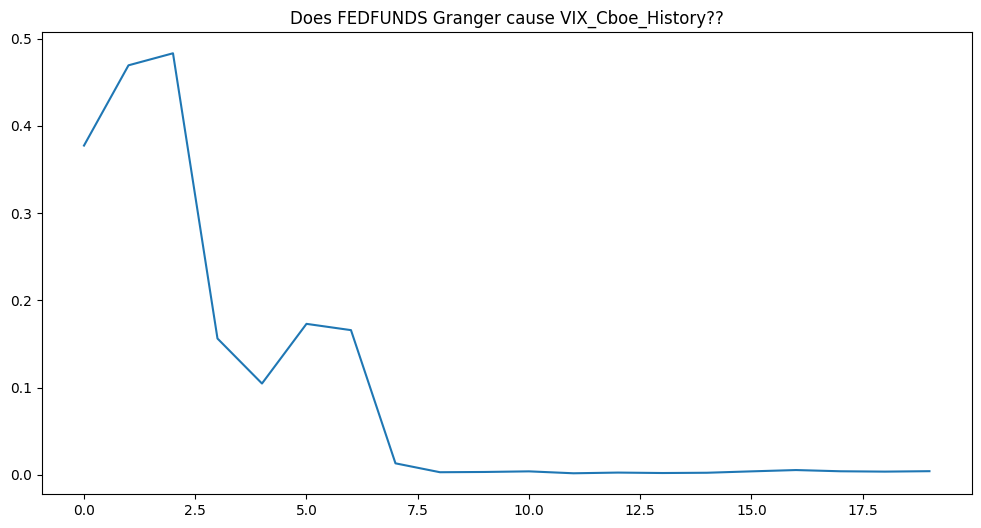

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


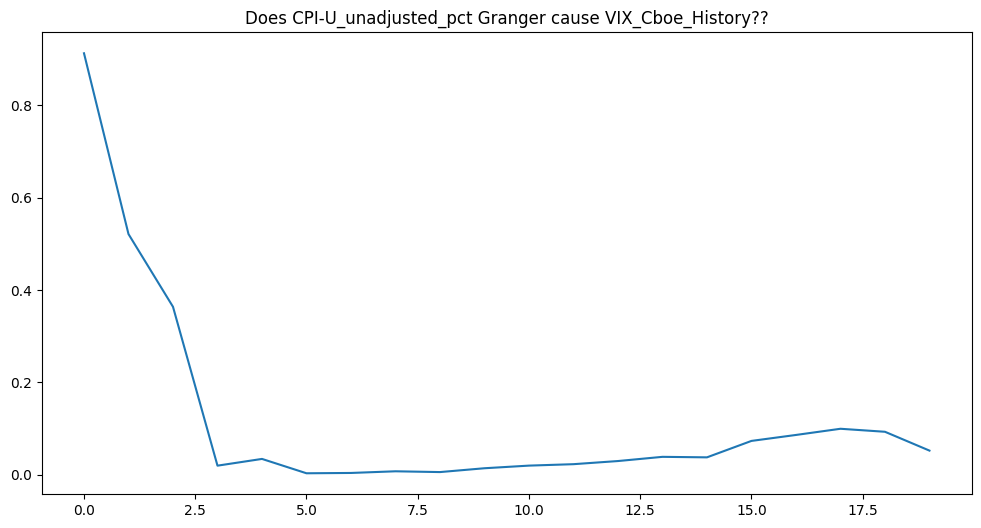

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


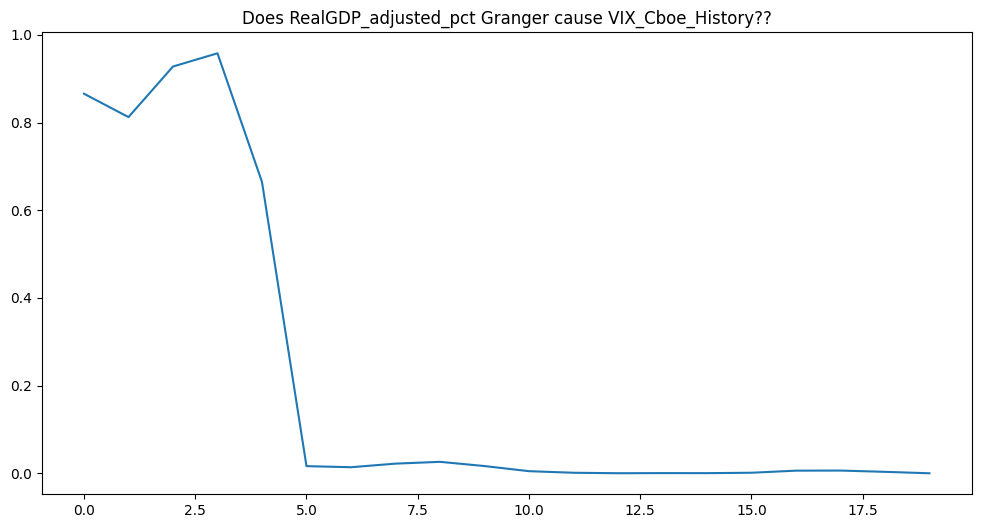

In [90]:
maxlag = 20
test = 'ssr_chi2test'
for name1 in ['FEDFUNDS', 'CPI-U_unadjusted_pct', 'RealGDP_adjusted_pct']:
    name2 = 'VIX_Cboe_History'
    # Interchanging the columns in below function to measure if name1 granger-causes name2
    df_clean = common_duration_interval(dfs_dict_train, name1, name2)

    granger_res = grangercausalitytests(df_clean, maxlag, verbose=False)
    p_values = [round(granger_res[i+1][0][test][1],4) for i in range(maxlag)]
    pd.Series(p_values).plot(title=f'Does {name1} Granger cause {name2}??',figsize=(12, 6))
    plt.show()

In [138]:
display(timeline_df)

,start,end,max_interval
Name,,,
10Yrs_Yield_unadjusted,1999-01-01,2025-12-31,3 days
CPI-U_unadjusted,1999-01-01,2025-12-01,31 days
FEDFUNDS,1999-01-01,2025-12-01,31 days
Industrial_Production,1999-01-01,2025-12-01,31 days
Initial_Jobless_Claims,1999-01-02,2025-12-27,7 days
MSCI_USA_Value_Index,1999-01-01,2025-12-01,31 days
RealGDP_adjusted,1999-01-01,2025-07-01,92 days
S&P_500_Earnings_History,1999-01-01,2025-12-01,31 days
VIX_Cboe_History,1999-01-04,2025-12-31,7 days


In [156]:
print(dfs_dict_train['S&P_500_Earnings_History'].head(23))

             S&P_value    EPS
DateTime                     
1999-01-01     1279.64  38.38
1999-02-01     1238.33  38.38
1999-03-01     1286.37  38.38
1999-04-01     1335.18  41.02
1999-05-01     1301.84  41.02
1999-06-01     1372.71  41.02
1999-07-01     1328.72  43.96
1999-08-01     1320.41  43.96
1999-09-01     1282.71  43.96
1999-10-01     1362.93  48.17
1999-11-01     1388.91  48.17
1999-12-01     1469.25  48.17
2000-01-01     1394.46  50.95
2000-02-01     1366.42  50.95
2000-03-01     1498.58  50.95
2000-04-01     1452.43  51.92
2000-05-01     1420.60  51.92
2000-06-01     1454.60  51.92
2000-07-01     1430.83  53.70
2000-08-01     1517.68  53.70
2000-09-01     1436.51  53.70
2000-10-01     1429.40  50.00
2000-11-01     1314.95  50.00


In [172]:
# ── 1. EXTRACT & RESAMPLE ─────────────────────────────────────────────
common_idx = pd.date_range('1999-02-01', '2019-12-01', freq='MS')

vix    = dfs_dict_train['VIX_Cboe_History']['CLOSE'].resample('MS').last().reindex(common_idx).ffill()
y10    = dfs_dict_train['10Yrs_Yield_unadjusted'].resample('MS').last().reindex(common_idx).ffill().squeeze()
fed    = dfs_dict_train['FEDFUNDS'].resample('MS').last().reindex(common_idx).ffill().squeeze()
cpi_pct    = dfs_dict_train['CPI-U_unadjusted_pct'].resample('MS').last().reindex(common_idx).ffill().squeeze()
ip_pct     = dfs_dict_train['Industrial_Production'].pct_change().resample('MS').last().reindex(common_idx).ffill().squeeze()
claims = dfs_dict_train['Initial_Jobless_Claims'].resample('MS').last().reindex(common_idx).ffill().squeeze()
msci_pct   = dfs_dict_train['MSCI_USA_Value_Index'].pct_change().resample('MS').last().reindex(common_idx).ffill().squeeze()
gdp_pct    = dfs_dict_train['RealGDP_adjusted_pct'].resample('MS').last().reindex(common_idx).ffill().squeeze()
eps_pct   = dfs_dict_train['S&P_500_Earnings_History']['EPS'].pct_change().resample('MS').last().reindex(common_idx).ffill().squeeze()

spread = y10 - fed
print(ip_pct.shape)

(251,)


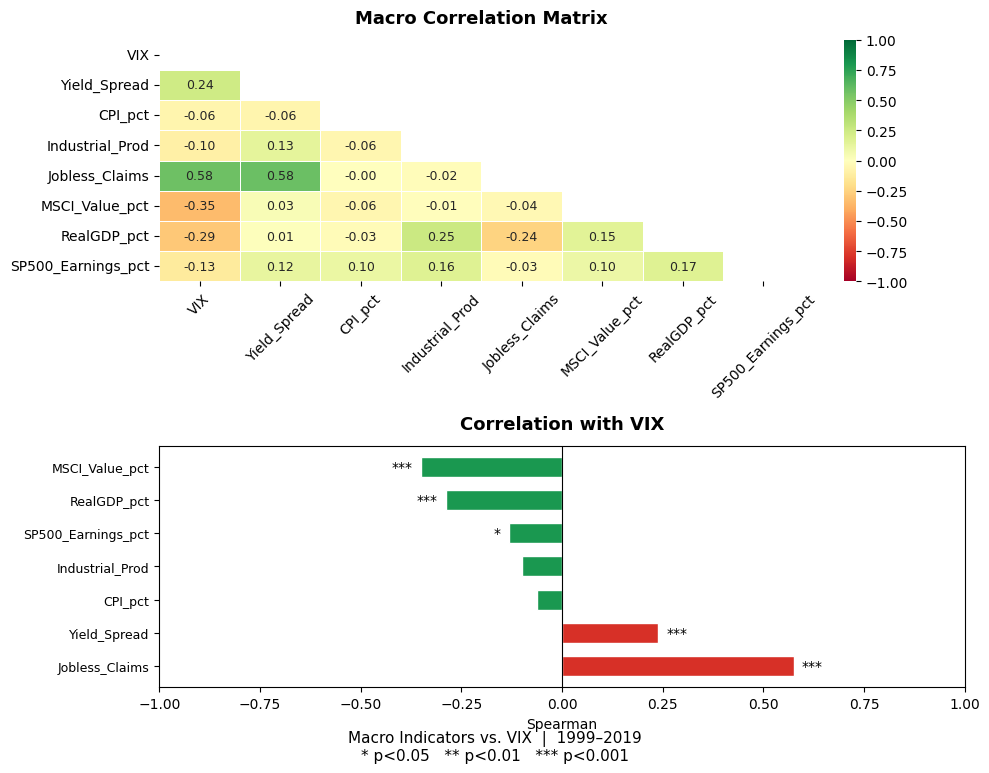

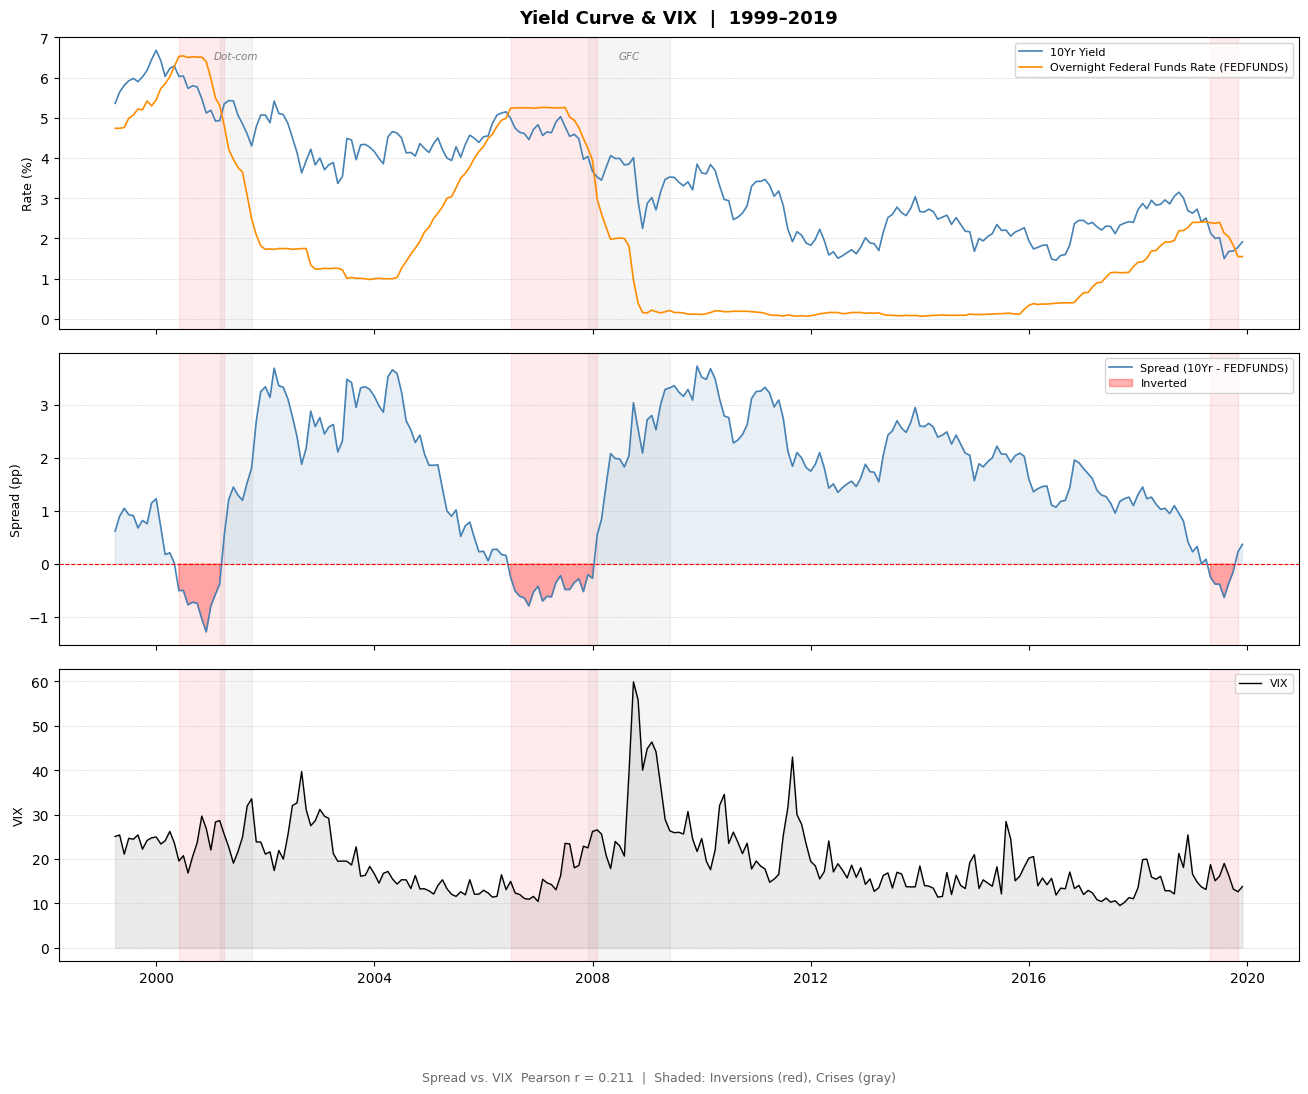

In [186]:
# ── 2. MASTER DATAFRAME ───────────────────────────────────────────────
df = pd.DataFrame({
    'VIX':                vix,
    'Yield_Spread':       spread,
    'CPI_pct':            cpi_pct,
    'Industrial_Prod':    ip_pct,
    'Jobless_Claims':     claims,
    'MSCI_Value_pct':         msci_pct,
    'RealGDP_pct':        gdp_pct,
    'SP500_Earnings_pct':     eps_pct
}).dropna()

# ════════════════════════════════════════════════════════════════════════
# VISUAL 1: CORRELATION HEATMAP
# ════════════════════════════════════════════════════════════════════════
corr = df.corr(method='spearman')
vix_corr = corr[['VIX']].drop('VIX').sort_values('VIX', ascending=False)

# p-values for VIX column
pvals = pd.Series({
    col: stats.spearmanr(df[col], df['VIX'])[1]
    for col in df.columns if col != 'VIX'
}, name='p_value').reindex(vix_corr.index)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                          gridspec_kw={'height_ratios': [1, 1]})

# Left: full correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', center=0,
            cmap='RdYlGn', linewidths=0.5, ax=ax1,
            vmin=-1, vmax=1, annot_kws={'size': 9})
ax1.set_title('Macro Correlation Matrix', fontsize=13, fontweight='bold', pad=12)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Right: VIX-specific bar chart sorted by correlation
colors = ['#d73027' if v > 0 else '#1a9850' for v in vix_corr['VIX']]
bars = ax2.barh(vix_corr.index, vix_corr['VIX'], color=colors, edgecolor='white', height=0.6)
ax2.axvline(0, color='black', linewidth=0.8)
ax2.set_xlim(-1, 1)
ax2.set_title('Correlation with VIX', fontsize=13, fontweight='bold', pad=12)
ax2.set_xlabel('Spearman')

# Annotate significance stars
for i, (idx, row) in enumerate(vix_corr.iterrows()):
    p = pvals[idx]
    star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    x_pos = row['VIX'] + (0.02 if row['VIX'] >= 0 else -0.02)
    ha = 'left' if row['VIX'] >= 0 else 'right'
    ax2.text(x_pos, i, star, va='center', ha=ha, fontsize=10, color='black')

ax2.tick_params(axis='y', labelsize=9)
fig.suptitle('Macro Indicators vs. VIX  |  1999–2019\n* p<0.05   ** p<0.01   *** p<0.001',
             fontsize=11, y=0.02)

plt.tight_layout()
plt.savefig('visual1_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# ════════════════════════════════════════════════════════════════════════
# VISUAL 2: YIELD CURVE + VIX TIME SERIES
# ════════════════════════════════════════════════════════════════════════
crisis_bands = [
    ('2001-03-01', '2001-10-01', 'Dot-com'),
    ('2007-12-01', '2009-06-01', 'GFC')
]

inversion_periods = []
in_inv = False
for date, val in df['Yield_Spread'].items():
    if val < 0 and not in_inv:
        start = date; in_inv = True
    elif val >= 0 and in_inv:
        inversion_periods.append((start, date)); in_inv = False

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                                      gridspec_kw={'hspace': 0.08})

# Panel 1: 10Yr and FEDFUNDS
ax1.plot(df.index, y10.reindex(df.index),   color='steelblue', linewidth=1.2, label='10Yr Yield')
ax1.plot(df.index, fed.reindex(df.index),   color='darkorange', linewidth=1.2, label='Overnight Federal Funds Rate (FEDFUNDS)')
ax1.set_ylabel('Rate (%)', fontsize=9)
ax1.legend(fontsize=8, loc='upper right')
ax1.set_title('Yield Curve & VIX  |  1999–2019', fontsize=13, fontweight='bold', pad=10)

# Panel 2: Spread
ax2.plot(df.index, df['Yield_Spread'], color='steelblue', linewidth=1.2, label='Spread (10Yr - FEDFUNDS)')
ax2.axhline(0, color='red', linestyle='--', linewidth=0.8)
ax2.fill_between(df.index, df['Yield_Spread'], 0,
                 where=df['Yield_Spread'] < 0, color='red', alpha=0.3, label='Inverted')
ax2.fill_between(df.index, df['Yield_Spread'], 0,
                 where=df['Yield_Spread'] >= 0, color='steelblue', alpha=0.12)
ax2.set_ylabel('Spread (pp)', fontsize=9)
ax2.legend(fontsize=8, loc='upper right')

# Panel 3: VIX
ax3.plot(df.index, df['VIX'], color='black', linewidth=1, label='VIX')
ax3.fill_between(df.index, df['VIX'], alpha=0.08, color='black')
ax3.set_ylabel('VIX', fontsize=9)
ax3.legend(fontsize=8, loc='upper right')

# Shade inversions and crises across all panels
for ax in [ax1, ax2, ax3]:
    for s, e in inversion_periods:
        ax.axvspan(s, e, alpha=0.08, color='red')
    for cs, ce, cl in crisis_bands:
        ax.axvspan(pd.Timestamp(cs), pd.Timestamp(ce),
                   alpha=0.08, color='gray')
    ax.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.6)

# Crisis labels on top panel only
for cs, ce, cl in crisis_bands:
    mid = pd.Timestamp(cs) + (pd.Timestamp(ce) - pd.Timestamp(cs)) / 2
    ax1.text(mid, ax1.get_ylim()[1] * 0.92, cl,
             ha='center', fontsize=7.5, color='gray', fontstyle='italic')

r_val, _ = stats.pearsonr(df['Yield_Spread'], df['VIX'])
fig.text(0.5, 0.01, f'Spread vs. VIX  Pearson r = {r_val:.3f}  |  Shaded: Inversions (red), Crises (gray)',
         ha='center', fontsize=9, color='dimgray')

plt.savefig('visual2_yieldcurve_vix.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
|